In [124]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import tqdm

import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from pyntcloud import PyntCloud

from dataset import ShapeNetDataset
from model import ClassificationNN, SegmentationNN, FeatureTransform, train, plot_stats
from torch.utils.data import DataLoader, random_split

In [125]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


![plot](images/model.png)

In [127]:
n = 10000
dataset_length = len(trainset)
train_ratio = 0.7
test_ratio = 0.3

model_file = 'pointnet_classification_model.pt'

train_len = int(dataset_length * train_ratio)
test_len = dataset_length - train_len

trainset = ShapeNetDataset("datasets/ModelNet10", train=True, n=n)
testset = ShapeNetDataset("datasets/ModelNet10", train=False, n=n)

trainset, testset = random_split(trainset, [train_len, test_len])


In [128]:
num_classes = 10
classification_model = ClassificationNN(num_classes).to(device)

In [129]:
lr = 0.0001
epochs = 1

model_file = 'pointnet_classification_model.pt'

optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)

if os.path.isfile(model_file):
    classification_model.load_state_dict(torch.load(model_file))
else:
    train(classification_model, trainset, validset, optimizer, epochs=epochs, device=device)
    torch.save(classification_model.state_dict(), model_file)

# ModelNet10 Dataset

The ModelNet10 Dataset features 5586 different pointcloud objects across 12 different classes. Below, we show the train/test split for each of the classes.

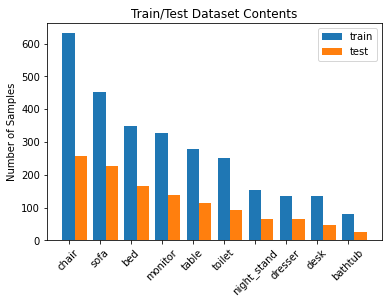

In [130]:
train_indices = trainset.indices
test_indices = testset.indices

dataset = ShapeNetDataset("datasets/ModelNet10", train=True, n=n)

train_class_counts = dataset.df.loc[train_indices, 'label'].value_counts()
test_class_counts = dataset.df.loc[test_indices, 'label'].value_counts()

x_labels = [dataset.classes[label] for label in train_class_counts.index]
x = range(len(x_labels))

plt.bar(x, train_class_counts, label='train', width=0.4)
plt.bar([xi + 0.4 for xi in range(len(x_labels))], test_class_counts, label='test', width=0.4)
plt.xticks([xi for xi in x], x_labels, rotation=45)
plt.ylabel('Number of Samples')
plt.title('Train/Test Dataset Contents')
plt.legend()

Here, we will show an example of a desk pointcloud. We first print out the first point of its representation. Note that it is a set of unordered (X, Y, Z) point.

In [131]:
for key, value in dataset.classes.items():
    if value == "desk":
        label = key
        break

idx = dataset.df[dataset.df['label'] == label].index[0]
point_cloud = dataset[idx]
first_point = point_cloud[0].tolist()  
print(f"Class: desk")
print("First point xyz coords")
print(f"x: {first_point[0][0]}, y: {first_point[1][0]}, z: {first_point[2][0]}")
print()

Class: desk
First point xyz coords
x: 4.644002914428711, y: 27.594783782958984, z: -8.511106491088867



Now, we will produce a scatter plot showing the desk's representation by plotting the (x, y, z) points on a 3D scatter plot.

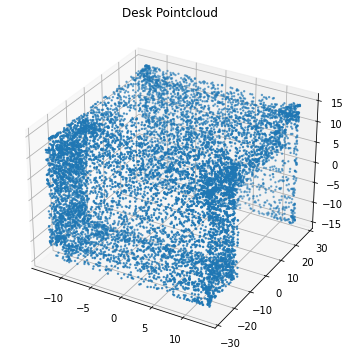

In [132]:
np_ptcld = point_cloud[0].numpy()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(np_ptcld[0], np_ptcld[1], np_ptcld[2], s=2)
plt.title('Desk Pointcloud')
plt.show()